In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#reading all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [6]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [64]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [118]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [117]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
C = torch.randn((27,2))

In [23]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [25]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [32]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

In [33]:
h

tensor([[ 0.3362, -0.9995,  0.9682,  ..., -0.9362, -0.6762,  0.9983],
        [-0.9487, -0.9988,  0.9854,  ..., -0.7873, -0.8217,  0.9975],
        [ 0.8040, -0.9934,  0.6737,  ..., -0.8532, -0.7489,  0.9952],
        ...,
        [-0.9491, -0.9086, -0.3102,  ..., -0.7671, -0.9873,  0.1183],
        [ 0.6516,  0.7320,  0.2739,  ...,  0.9954,  0.5207,  0.8993],
        [ 0.9269, -0.5958,  0.4383,  ..., -0.6832, -0.5105, -0.5628]])

In [34]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([32, 27])

In [37]:
counts = logits.exp()

In [38]:
prob = counts/ counts.sum(1, keepdims = True)

In [39]:
prob.shape

torch.Size([32, 27])

In [44]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(15.1560)

In [45]:
# ------------ now made respectable :) ---------------


In [119]:
# X.shape, Y.shape # dataset
Xtr.shape, Ytr.shape # dataset


(torch.Size([182580, 3]), torch.Size([182580]))

In [149]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [150]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [151]:
for p in parameters:
    p.requires_grad = True

In [152]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
#lrs

In [153]:
lri = []
lossi = []
stepi = []

In [159]:
for i in range(50000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
#forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
    logits = h @ W2+b2 #32,27
    # counts = logits.exp()
    # prob = counts/counts.sum(1, keepdims = True)
    # loss = -prob[torch.arange(32),Y].log().mean()
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

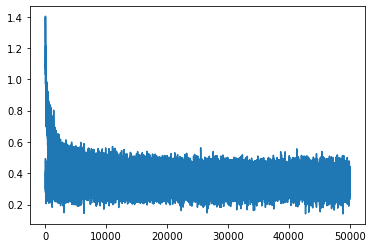

In [160]:
plt.plot(stepi,lossi)

In [161]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
logits = h @ W2+b2 #32,27
loss = F.cross_entropy(logits,Ytr)
loss.item()

2.1749093532562256

In [162]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #32,100
logits = h @ W2+b2 #32,27
loss = F.cross_entropy(logits,Ydev)
loss.item()

2.197167158126831

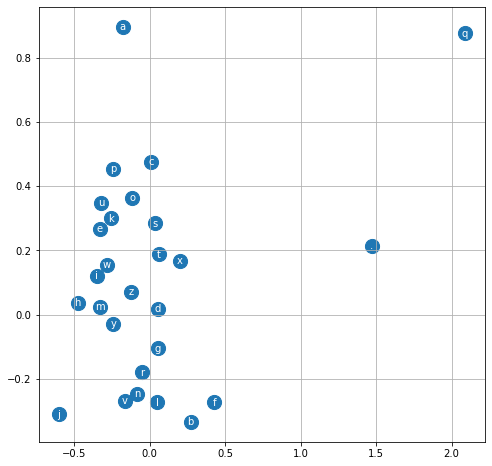

In [163]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [164]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [165]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ami.
heri.
kimli.
reviyah.
cassie.
rahnen.
delyah.
jareei.
nerania.
chaii.
des.
egy.
dham.
jori.
quint.
shon.
walia.
bick.
jerogdiarynix.
